In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets
file_path_1 = 'Unemployment in India.csv'
file_path_2 = 'Unemployment_Rate_upto_11_2020.csv'

In [5]:
data1 = pd.read_csv(file_path_1)
data2 = pd.read_csv(file_path_2)

In [7]:
# Inspect column names
print("Dataset 1 Columns:", data1.columns)
print("Dataset 2 Columns:", data2.columns)

Dataset 1 Columns: Index(['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)',
       ' Estimated Employed', ' Estimated Labour Participation Rate (%)',
       'Area'],
      dtype='object')
Dataset 2 Columns: Index(['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)',
       ' Estimated Employed', ' Estimated Labour Participation Rate (%)',
       'Region.1', 'longitude', 'latitude'],
      dtype='object')


In [9]:
# Check for 'Unemployment Rate' or similar column names
# Adjust column names as needed
data1.columns = data1.columns.str.strip()  # Remove leading/trailing spaces
data2.columns = data2.columns.str.strip()

In [13]:
# Merge datasets if they share a common column like 'Date'
if 'Date' in data1.columns and 'Date' in data2.columns:
    # Specify dayfirst=True to handle DD-MM-YYYY format
    data1['Date'] = pd.to_datetime(data1['Date'], dayfirst=True, errors='coerce')
    data2['Date'] = pd.to_datetime(data2['Date'], dayfirst=True, errors='coerce')
    data = pd.merge(data1, data2, on='Date', how='outer')
else:
    data = data1  # Or analyze separately


In [15]:
# Handle missing values
data = data.dropna()

In [17]:
# Check for the actual column name related to Unemployment Rate
# Update the plot accordingly
unemployment_rate_column = None
for col in data.columns:
    if 'unemployment' in col.lower():
        unemployment_rate_column = col
        break

if not unemployment_rate_column:
    raise ValueError("No column related to 'Unemployment Rate' found in the dataset.")

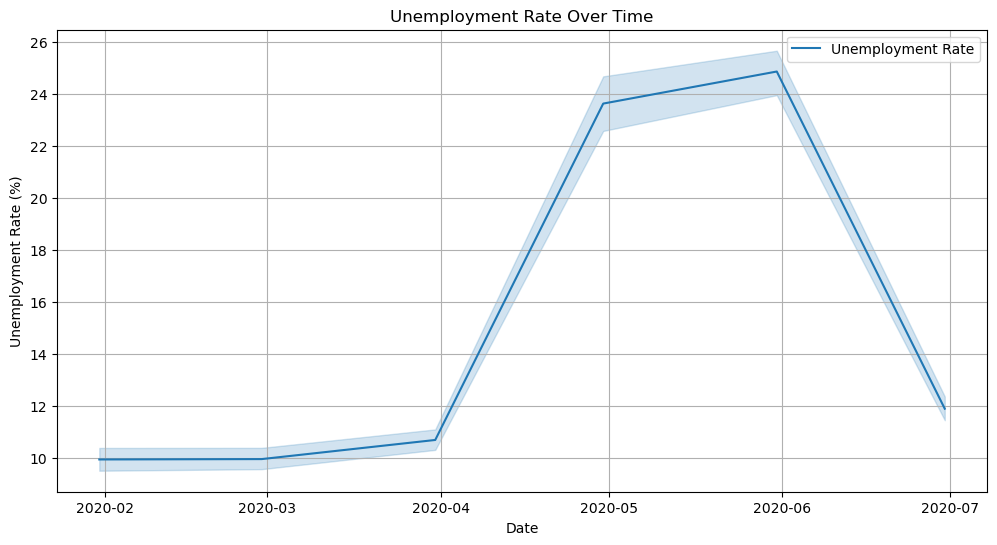

In [19]:
# Visualization of Unemployment Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y=unemployment_rate_column, label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Regional Analysis (if applicable)
if 'Region' in data.columns:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=data, x='Region', y=unemployment_rate_column)
    plt.title('Unemployment Rate by Region')
    plt.xlabel('Region')
    plt.ylabel('Unemployment Rate (%)')
    plt.xticks(rotation=45)
    plt.show()

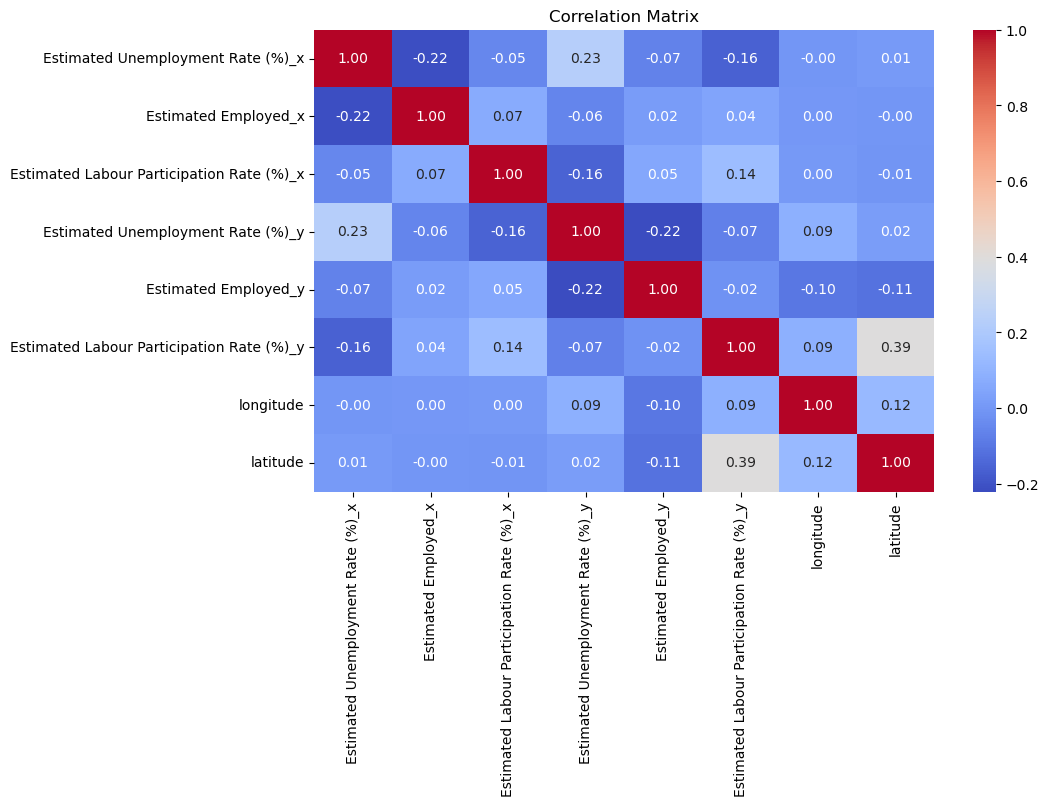

In [25]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Correlation Analysis on numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [29]:
import os

# Define the directory and file path
directory = '/mnt/data'
cleaned_file_path = os.path.join(directory, 'Cleaned_Unemployment_Data.csv')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save cleaned data to the file
data.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")


Cleaned data saved to /mnt/data\Cleaned_Unemployment_Data.csv


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
# Preprocessing
data1.columns = data1.columns.str.strip()
data2.columns = data2.columns.str.strip()
data1['Date'] = pd.to_datetime(data1['Date'], errors='coerce')
data2['Date'] = pd.to_datetime(data2['Date'], errors='coerce')
data = pd.merge(data1, data2, on='Date', how='outer').dropna()

In [35]:
# Identify unemployment rate column
unemployment_rate_column = [col for col in data.columns if 'unemployment' in col.lower()][0]

In [37]:
# Handle outliers
q1 = data[unemployment_rate_column].quantile(0.25)
q3 = data[unemployment_rate_column].quantile(0.75)
iqr = q3 - q1
outlier_threshold = 1.5 * iqr
data = data[(data[unemployment_rate_column] >= q1 - outlier_threshold) & 
            (data[unemployment_rate_column] <= q3 + outlier_threshold)]

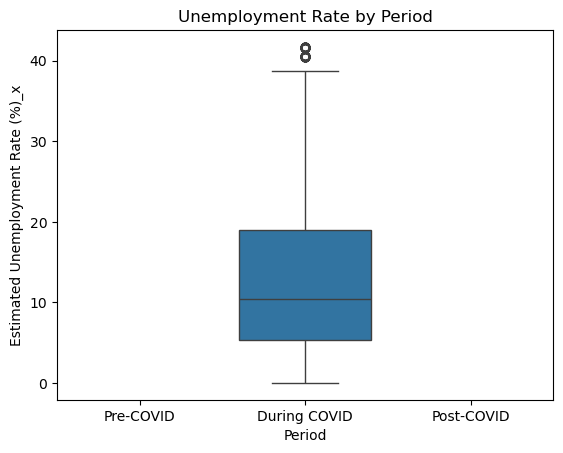

In [39]:
# Trend Analysis: Pre-COVID, During COVID, Post-COVID
data['Year'] = data['Date'].dt.year
data['Period'] = pd.cut(data['Year'], bins=[2018, 2019, 2020, 2022], labels=['Pre-COVID', 'During COVID', 'Post-COVID'])
sns.boxplot(data=data, x='Period', y=unemployment_rate_column)
plt.title('Unemployment Rate by Period')
plt.show()

In [41]:
# Regional Analysis
if 'Region' in data.columns:
    region_means = data.groupby('Region')[unemployment_rate_column].mean().sort_values()
    sns.barplot(x=region_means.index, y=region_means.values)
    plt.title('Average Unemployment Rate by Region')
    plt.xticks(rotation=45)
    plt.show()

In [43]:
# Statistical Testing: Compare Periods
pre_covid = data[data['Period'] == 'Pre-COVID'][unemployment_rate_column]
during_covid = data[data['Period'] == 'During COVID'][unemployment_rate_column]
post_covid = data[data['Period'] == 'Post-COVID'][unemployment_rate_column]

In [45]:
# T-test for significant difference
t_stat, p_val = ttest_ind(pre_covid, during_covid, equal_var=False)
print(f"T-test between Pre-COVID and During COVID: T-stat={t_stat}, P-value={p_val}")

T-test between Pre-COVID and During COVID: T-stat=nan, P-value=nan


In [47]:
# ANOVA for multi-group comparison
f_stat, p_val_anova = f_oneway(pre_covid, during_covid, post_covid)
print(f"ANOVA across periods: F-stat={f_stat}, P-value={p_val_anova}")

ANOVA across periods: F-stat=nan, P-value=nan


C:\Users\ASUS\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


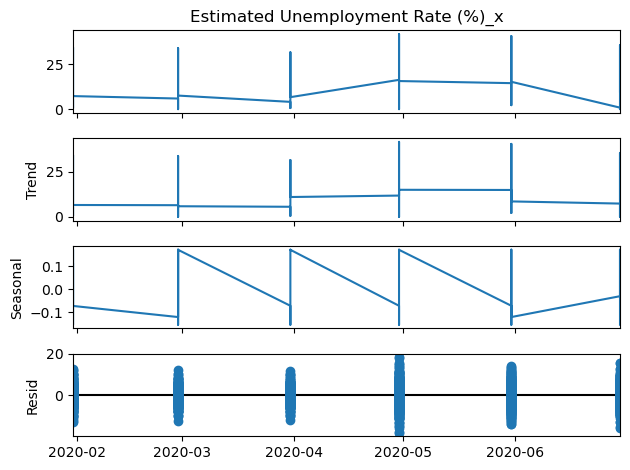

In [49]:
# Time Series Decomposition
time_series = data.set_index('Date')[unemployment_rate_column]
decomposition = seasonal_decompose(time_series, model='additive', period=12)
decomposition.plot()
plt.show()

In [51]:
# Predictive Modeling (Simple Linear Regression)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [53]:
data['NumericDate'] = data['Date'].map(lambda x: x.toordinal())  # Convert dates to numeric for regression
X = data[['NumericDate']]
y = data[unemployment_rate_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Linear Regression MSE: {mse}")

Linear Regression MSE: 87.07331345385819


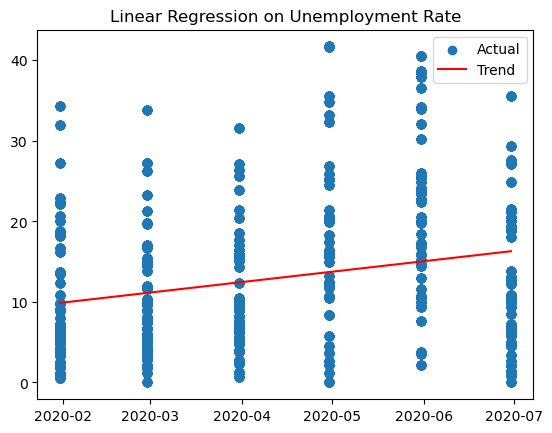

In [57]:
plt.scatter(data['Date'], data[unemployment_rate_column], label='Actual')
plt.plot(data['Date'], model.predict(X), color='red', label='Trend')
plt.legend()
plt.title('Linear Regression on Unemployment Rate')
plt.show()